In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-data-engineered/stroke_data_engineered.csv
/kaggle/input/stroke-data-engineered/stroke_data_engineered_2.csv
/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVR
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [3]:
stroke_data = pd.read_csv("../input/stroke-data-engineered/stroke_data_engineered_2.csv")

In [4]:
X_train, X_test, y_train, y_test = train_test_split(stroke_data.drop(columns=["id", "stroke"]),
                                                    stroke_data['stroke'], 
                                                    test_size=0.5, 
                                                    random_state=125)

**Hyperparameter Optimisation**

In [5]:
param_grid = {'C': [0.01, 0.1,1, 10, 100, 1000, 5000, 10000, 20000], 
              'gamma': [10, 1,0.1,0.01,0.001,0.0001, 0.00001, 0.000001], 
              'kernel': ['rbf'],
             }

model = SVR()

grid = RandomizedSearchCV(model, param_grid, scoring="neg_mean_squared_error", verbose=3, cv=10)

In [6]:
# %%time
# grid.fit(X_train,y_train)

In [7]:
# grid.best_params_

**Best parameters:** {'C': 0.1, 'gamma': 1e-06, 'kernel': 'rbf'}

{'kernel': 'rbf', 'gamma': 0.01, 'C': 10000}


**End of Hyperparameter Optimisation**

The best parameters above ended up not working that great, so I played around with the parameters a little. The goal being to spread the graph(below) out a little, in order to make it easier to decide on a threshold.

Results are not bad, but there was a lot of experimenting(which we could consider a target leakage). However, I believe the method of looking at the distribution and deciding on a threshold could work well since you are not getting any target leakage, and only looking at your predictions.

Parameters I settled on: {'kernel': 'rbf', 'gamma': 0.0000001, 'C': 20000}

In [8]:
%%time
model = SVR(C=20000, gamma=0.0000001, kernel='rbf')

model.fit(X_train, y_train)

predictions = model.predict(X_test)

CPU times: user 34.5 s, sys: 11.4 ms, total: 34.5 s
Wall time: 34.5 s


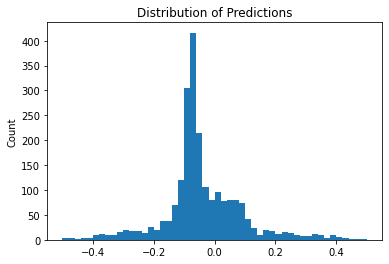

In [9]:
plt.hist(predictions, bins=50, range=[-0.5,0.5])
plt.title("Distribution of Predictions")
plt.ylabel("Count")
plt.show()

In [10]:
# set predictions in the interval (-0.2, 0.1) to zero, and one otherwise
# interval chosen by analysing the distribution of predictions above

predict = []
for pred in predictions.tolist():
    if -0.2 < pred < 0.2:
        predict.append(0)
    else:
        predict.append(1)

predict = np.array(predict)

In [11]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      2428
           1       0.12      0.58      0.19       127

    accuracy                           0.76      2555
   macro avg       0.54      0.68      0.53      2555
weighted avg       0.93      0.76      0.83      2555



Text(0.5, 1.0, 'Confusion Matrix for Support Vector Regressor Prediction')

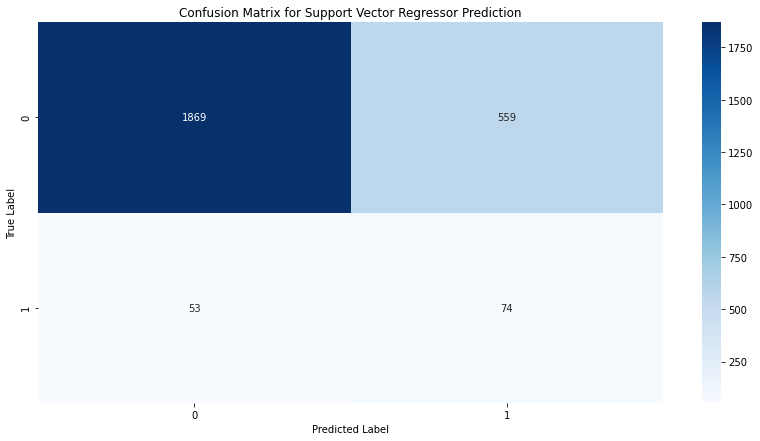

In [12]:
conf_matrix = confusion_matrix(y_test, predict)

plt.figure(figsize=(14,7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cbar=True, cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Support Vector Regressor Prediction")